# Install dependencies, import modules, input credentials

In [ ]:
!pip install praw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import praw
from datetime import datetime
import logging
import time
from prawcore.exceptions import TooManyRequests
import pandas as pd
from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

NameError: ignored

In [ ]:
client_id = ""
client_secret = ""

reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent="Scraper",
)

In [ ]:
# suppress warnings from PRAW
logging.getLogger('praw').setLevel(logging.ERROR)

# Defining Functions

In [ ]:
def create_submission_dict(submission): # submission = reddit.submission(id=submission_id) or submission = reddit.submission(url=submission_url)
    time = datetime.utcfromtimestamp(submission.created_utc).strftime('%Y-%m-%d %H:%M:%S')
    if type(submission.edited) == bool :
        edited = submission.edited
    else :
        edited = datetime.utcfromtimestamp(submission.edited).strftime('%Y-%m-%d %H:%M:%S')

    submission_data = {
        'id': submission.id,
        'full_id': submission.name,
        'author': str(submission.author),
        'title': submission.title,
        'text': submission.selftext,
        'url': submission.url,
        'is_self': submission.is_self,
        'created_utc': time,
        'edited': edited,
        'num_comments': submission.num_comments,
        'is_locked': submission.locked,
        'is_over_18': submission.over_18,
        'score': submission.score,
        'upvote_ratio' : submission.upvote_ratio,
        'link': submission.permalink
    }

    return submission_data

In [ ]:
def create_comment_dict(comment):
    if "AutoModerator" in str(comment.author) :
        return None

    time = datetime.utcfromtimestamp(comment.created_utc).strftime('%Y-%m-%d %H:%M:%S')
    if type(comment.edited) == bool :
        edited = comment.edited
    else :
        edited = datetime.utcfromtimestamp(comment.edited).strftime('%Y-%m-%d %H:%M:%S')

    comment_data = {
        'id': comment.id,
        'author': str(comment.author),
        'body': comment.body,
        'created_utc': time,
        'edited': edited,
        'distinguished': comment.distinguished,
        'replies': len(comment.replies),
        'submission_id': comment.link_id,
        'parent_id' : comment.parent_id,
        'is_submitter': comment.is_submitter,
        'is_stickied': comment.stickied,
        'score': comment.score,
        'link': comment.permalink
    }

    return comment_data

# Getting submissions

In [ ]:
subreddit = reddit.subreddit("adhd")

In [ ]:
# collect all submissions

submissions_data = []

progress_bar = tqdm(total = 1000, desc="Fetching submissions")
for submission in subreddit.new(limit = 1000):
    try :
        submission_data = create_submission_dict(submission)
        if submission_data['num_comments'] <= 1 :
            continue
        else :
            submissions_data.append(submission_data)

    except TooManyRequests as e :
        print(e)
        print("\n")
        time.sleep(60)

    except Exception as e:
        print(e)
        print(submission.id)
        print("\n")
        continue

    progress_bar.update(1)

progress_bar.close()

submissions_df = pd.DataFrame(submissions_data)

Fetching submissions:  99%|█████████▉| 993/1000 [00:10<00:00, 97.31it/s] 


In [ ]:
submissions_df.tail()

id     full_id              author  \
988  1750k45  t3_1750k45                None   
989  1750dsm  t3_1750dsm          lavacahawk   
990  174zuut  t3_174zuut  green_metal_bottle   
991  174ztrs  t3_174ztrs            Kates_up   
992  174zsxh  t3_174zsxh   Admirable-Log7202   

                                                 title  \
988                     Issues with calling pharmacies   
989                         ADHD in the school setting   
990    Emotional dysregulation in reaction to vyvanse?   
991  I straight up just don’t eat and it’s borderli...   
992                       People just…pick up degrees?   

                                                  text  \
988  I called 30+ pharmacies last week to get my pr...   
989  I work closely with students with impairments ...   
990  Not sure if this is the right flare but couldn...   
991  I’ve struggled my whole life with eating becau...   
992  So.. you’re telling me most people actually ch...   

                                                   url  is_self  \
988  https://www.reddit.com/r/ADHD/comments/1750k45...     True   
989  https://www.reddit.com/r/ADHD/comments/1750dsm...     True   
990  https://www.reddit.com/r/ADHD/comments/174zuut...     True   
991  https://www.reddit.com/r/ADHD/comments/174ztrs...     True   
992  https://www.reddit.com/r/ADHD/comments/174zsxh...     True   

             created_utc               edited  num_comments  is_locked  \
988  2023-10-11 00:17:39                False             4      False   
989  2023-10-11 00:09:16                False             1      False   
990  2023-10-10 23:45:09                False             1      False   
991  2023-10-10 23:43:44                False             2      False   
992  2023-10-10 23:42:37  2023-10-11 00:00:14            43      False   

     is_over_18  score  upvote_ratio  \
988       False      2          1.00   
989       False      3          1.00   
990       False      1          0.67   
991       False      1          1.00   
992       False    145          0.94   

                                                  link  
988  /r/ADHD/comments/1750k45/issues_with_calling_p...  
989  /r/ADHD/comments/1750dsm/adhd_in_the_school_se...  
990  /r/ADHD/comments/174zuut/emotional_dysregulati...  
991  /r/ADHD/comments/174ztrs/i_straight_up_just_do...  
992  /r/ADHD/comments/174zsxh/people_justpick_up_de...

In [ ]:
submissions_df.dtypes

id               object
full_id          object
author           object
title            object
text             object
url              object
is_self            bool
created_utc      object
edited           object
num_comments      int64
is_locked          bool
is_over_18         bool
score             int64
upvote_ratio    float64
link             object
dtype: object

In [ ]:
print("Size of the dataset:", submissions_df.shape)
print('----------')

print("Most active submitters:")
for mode in submissions_df['author'].mode() :
    mode_count = submissions_df['author'].value_counts()[mode]
    print(f"\t{mode}: {mode_count}")
print('----------')

print("Number of comments:", f"\n\tTotal: {submissions_df['num_comments'].sum()}", f"\n\tMean: {submissions_df['num_comments'].mean()}", f"\n\tMax: {submissions_df['num_comments'].max()}", f"\n\tMin: {submissions_df['num_comments'].min()}")
print("Submissions with no comments:", len(submissions_df.loc[submissions_df['num_comments'] <= 1]))
print('----------')
print("Score:", f"\n\tMean: {submissions_df['score'].mean()}", f"\n\tMax: {submissions_df['score'].max()}", f"\n\tMin: {submissions_df['score'].min()}")
print('----------')
print("Upvote ratio:", f"\n\tMean: {submissions_df['upvote_ratio'].mean()}", f"\n\tMax: {submissions_df['upvote_ratio'].max()}", f"\n\tMin: {submissions_df['upvote_ratio'].min()}")

Size of the dataset: (993, 15)
----------
Most active submitters:
	BrokenScrew5150: 5
	catboy519: 5
----------
Number of comments: 
	Total: 11661 
	Mean: 11.743202416918429 
	Max: 719 
	Min: 0
Submissions with no comments: 338
----------
Score: 
	Mean: 19.122860020140987 
	Max: 1616 
	Min: 0
----------
Upvote ratio: 
	Mean: 0.937583081570997 
	Max: 1.0 
	Min: 0.25


In [ ]:
submissions_df['created_utc'] = pd.to_datetime(submissions_df['created_utc'])

# Find the earliest date using min()
earliest_date = submissions_df['created_utc'].min()
print(earliest_date)

2023-10-10 13:32:31


In [ ]:
submissions_df.to_csv("/content/comm557_submissions_df.csv")

In [ ]:
submissions_df.to_csv("/content/drive/MyDrive/comm557_submissions_df.csv")

# Getting comments from submissions

In [ ]:
comments_data = []

for index, row in tqdm(submissions_df.iterrows(), total=len(submissions_df), desc="Processing comments under submissions"):

    submission_id = row['id']

    try :
        submission = reddit.submission(id = submission_id)
        submission.comments.replace_more(limit = None)

    except TooManyRequests as e :
            print(e)
            print("\n")
            time.sleep(60)

    except Exception as e:
        print(e)
        print(comment.id)
        print("\n")
        continue

    # iterate through comments in submission
    for comment in submission.comments.list():
        try :
            comment_data = create_comment_dict(comment)

            if comment_data is None :
                continue
            else :
                comments_data.append(comment_data)

        except TooManyRequests as e :
            print(e)
            print("\n")
            time.sleep(60)

        except Exception as e:
            print(e)
            print(comment.id)
            print("\n")
            continue


comments_df = pd.DataFrame(comments_data)

Processing comments under submissions:  60%|██████    | 598/993 [08:46<05:18,  1.24it/s]

received 429 HTTP response




Processing comments under submissions: 100%|██████████| 993/993 [17:24<00:00,  1.05s/it]


In [ ]:
comments_df.head()

id           author  \
0  k53n1ca  throwawaytheist   
1  k53pelr       No-Sea1173   
2  k53nmyv       Erpelpelle   
3  k53o6hz  Cursed_Creative   
4  k53kt93     CaberTosser_   

                                                body          created_utc  \
0  The Anti Planner\n\nIt's literally just a list...  2023-10-16 11:12:54   
1  Don't know any books sorry. \n\nMaybe this wil...  2023-10-16 11:37:22   
2  You can try to focus on your breathing, recogn...  2023-10-16 11:19:19   
3  Not to discourage you, but just for N=1, my ex...  2023-10-16 11:24:57   
4  Yeah. Dopamine deficiency and depression can c...  2023-10-16 10:48:09   

  edited distinguished  replies submission_id   parent_id  is_submitter  \
0  False          None        0    t3_1793g27  t3_1793g27         False   
1  False          None        0    t3_1793g27  t3_1793g27         False   
2  False          None        0    t3_1793f20  t3_1793f20         False   
3  False          None        0    t3_1792v8g  t3_1792v8g         False   
4  False          None        0    t3_1792p91  t3_1792p91         False   

   is_stickied  score                                               link  
0        False      1  /r/ADHD/comments/1793g27/what_are_books_with_o...  
1        False      1  /r/ADHD/comments/1793g27/what_are_books_with_o...  
2        False      1  /r/ADHD/comments/1793f20/teach_me_how_to_be_qu...  
3        False      1  /r/ADHD/comments/1792v8g/research_student_prod...  
4        False      2  /r/ADHD/comments/1792p91/i_dont_remember_anyth...

In [ ]:
comments_df.dtypes

id               object
author           object
body             object
created_utc      object
edited           object
distinguished    object
replies           int64
submission_id    object
parent_id        object
is_submitter       bool
is_stickied        bool
score             int64
link             object
dtype: object

In [ ]:
print("Size of the dataset:", comments_df.shape)
print('----------')

print("Most active commenters:")
for mode in comments_df['author'].mode() :
    mode_count = comments_df['author'].value_counts()[mode]
    print(f"\t{mode}: {mode_count}")
print('----------')

print("Number of replies to comments:", f"\n\tTotal: {comments_df['replies'].sum()}", f"\n\tMean: {comments_df['replies'].mean()}", f"\n\tMax: {comments_df['replies'].max()}", f"\n\tMin: {comments_df['replies'].min()}")
print('----------')
print("Score:", f"\n\tMean: {comments_df['score'].mean()}", f"\n\tMax: {comments_df['score'].max()}", f"\n\tMin: {comments_df['score'].min()}")

Size of the dataset: (10486, 13)
----------
Most active commenters:
	None: 79
----------
Number of replies to comments: 
	Total: 4114 
	Mean: 0.3923326339881747 
	Max: 59 
	Min: 0
----------
Score: 
	Mean: 6.162979210375739 
	Max: 1934 
	Min: -24


In [ ]:
comments_df.to_csv("/content/comm557_comments_df.csv")

In [ ]:
comments_df.to_csv("/content/drive/MyDrive/comm557_comments_df.csv")

In [ ]:
# getting comments that are under other comments
comments_to_comments_df = comments_df[(comments_df.parent_id.str.startswith('t1'))]
comments_to_comments_df

id           author  \
10     k53hxgg     NOTeRcHAThiO   
12     k53d8tr      ItsAleexB21   
13     k53ed1w  Debaucherous-Me   
14     k53fsmn      ItsAleexB21   
15     k53g3ik  Debaucherous-Me   
...        ...              ...   
10481  k4egf30   saggywitchtits   
10482  k4f3hz8     GreatBox4208   
10483  k4flh0e          lghtspd   
10484  k4etecp         honeygl0   
10485  k4fvp08      Bartowskiii   

                                                    body          created_utc  \
10     Don’t the first 6 override the 12 that follow?...  2023-10-16 10:13:10   
12     problem is that i've had the referral. i've ha...  2023-10-16 09:10:52   
13     Who was the referrals to? I psychiatrist could...  2023-10-16 09:26:06   
14     they were two separate consultants. for anythi...  2023-10-16 09:45:37   
15     That system is bullshit! Once I had my referra...  2023-10-16 09:49:38   
...                                                  ...                  ...   
10481  I have enough credits to graduate from my comm...  2023-10-11 11:01:11   
10482  I feel you. I registered for two classes this ...  2023-10-11 14:08:41   
10483  I did 1 online class per semester while workin...  2023-10-11 16:01:06   
10484  This was my problem. I’m kind of a commitment-...  2023-10-11 12:56:35   
10485              Adhd and picking psychology? Never! 😂  2023-10-11 17:02:22   

      edited distinguished  replies submission_id   parent_id  is_submitter  \
10     False          None        0    t3_1791ysk  t1_k53fshg          True   
12     False          None        1    t3_1791d27  t1_k53c607          True   
13     False          None        1    t3_1791d27  t1_k53d8tr         False   
14     False          None        1    t3_1791d27  t1_k53ed1w          True   
15     False          None        1    t3_1791d27  t1_k53fsmn         False   
...      ...           ...      ...           ...         ...           ...   
10481  False          None        1    t3_174zsxh  t1_k4dt2aw         False   
10482  False          None        0    t3_174zsxh  t1_k4dnu7e         False   
10483  False          None        0    t3_174zsxh  t1_k4dnu7e         False   
10484  False          None        1    t3_174zsxh  t1_k4egf30         False   
10485  False          None        0    t3_174zsxh  t1_k4etecp         False   

       is_stickied  score                                               link  
10           False      1  /r/ADHD/comments/1791ysk/is_it_just_me_or_coul...  
12           False      1  /r/ADHD/comments/1791d27/how_to_cope_with_adhd...  
13           False      1  /r/ADHD/comments/1791d27/how_to_cope_with_adhd...  
14           False      1  /r/ADHD/comments/1791d27/how_to_cope_with_adhd...  
15           False      1  /r/ADHD/comments/1791d27/how_to_cope_with_adhd...  
...            ...    ...                                                ...  
10481        False      5  /r/ADHD/comments/174zsxh/people_justpick_up_de...  
10482        False      2  /r/ADHD/comments/174zsxh/people_justpick_up_de...  
10483        False      2  /r/ADHD/comments/174zsxh/people_justpick_up_de...  
10484        False      3  /r/ADHD/comments/174zsxh/people_justpick_up_de...  
10485        False      3  /r/ADHD/comments/174zsxh/people_justpick_up_de...  

[4100 rows x 13 columns]

In [ ]:
# getting comments that are directly under submissions & are not made by the submitter
comments_to_submissions_df = comments_df[(comments_df.is_submitter == False) & (comments_df.parent_id.str.startswith('t3'))]
comments_to_submissions_df

id                author  \
0      k53n1ca       throwawaytheist   
1      k53pelr            No-Sea1173   
2      k53nmyv            Erpelpelle   
3      k53o6hz       Cursed_Creative   
4      k53kt93          CaberTosser_   
...        ...                   ...   
10464  k4hkf0w          No_Store4228   
10465  k4hp6a0                ldrw95   
10466  k4hsu43            screamr123   
10467  k4j16zc  Fine-Construction952   
10468  k4jkk6j      Helpful-Cup-1211   

                                                    body          created_utc  \
0      The Anti Planner\n\nIt's literally just a list...  2023-10-16 11:12:54   
1      Don't know any books sorry. \n\nMaybe this wil...  2023-10-16 11:37:22   
2      You can try to focus on your breathing, recogn...  2023-10-16 11:19:19   
3      Not to discourage you, but just for N=1, my ex...  2023-10-16 11:24:57   
4      Yeah. Dopamine deficiency and depression can c...  2023-10-16 10:48:09   
...                                                  ...                  ...   
10464  I have ADHD and I have a degree. But earning a...  2023-10-11 23:14:27   
10465  Have two degrees but one is mostly useless. I ...  2023-10-11 23:46:52   
10466  I can relate, but had a different experience.\...  2023-10-12 00:11:48   
10467  what i did is manipulate my brain into doing a...  2023-10-12 06:15:28   
10468  Your ego limits you. I don’t mean this dispara...  2023-10-12 10:26:45   

      edited distinguished  replies submission_id   parent_id  is_submitter  \
0      False          None        0    t3_1793g27  t3_1793g27         False   
1      False          None        0    t3_1793g27  t3_1793g27         False   
2      False          None        0    t3_1793f20  t3_1793f20         False   
3      False          None        0    t3_1792v8g  t3_1792v8g         False   
4      False          None        0    t3_1792p91  t3_1792p91         False   
...      ...           ...      ...           ...         ...           ...   
10464  False          None        0    t3_174zsxh  t3_174zsxh         False   
10465  False          None        0    t3_174zsxh  t3_174zsxh         False   
10466  False          None        0    t3_174zsxh  t3_174zsxh         False   
10467  False          None        0    t3_174zsxh  t3_174zsxh         False   
10468  False          None        0    t3_174zsxh  t3_174zsxh         False   

       is_stickied  score                                               link  
0            False      1  /r/ADHD/comments/1793g27/what_are_books_with_o...  
1            False      1  /r/ADHD/comments/1793g27/what_are_books_with_o...  
2            False      1  /r/ADHD/comments/1793f20/teach_me_how_to_be_qu...  
3            False      1  /r/ADHD/comments/1792v8g/research_student_prod...  
4            False      2  /r/ADHD/comments/1792p91/i_dont_remember_anyth...  
...            ...    ...                                                ...  
10464        False      1  /r/ADHD/comments/174zsxh/people_justpick_up_de...  
10465        False      1  /r/ADHD/comments/174zsxh/people_justpick_up_de...  
10466        False      1  /r/ADHD/comments/174zsxh/people_justpick_up_de...  
10467        False      1  /r/ADHD/comments/174zsxh/people_justpick_up_de...  
10468        False      1  /r/ADHD/comments/174zsxh/people_justpick_up_de...  

[6363 rows x 13 columns]

In [ ]:
# comments to comments
df1 = comments_to_comments_df[['author', 'parent_id', 'body']].copy()
df1['parent_id'] = df1['parent_id'].str.split('_').str[-1]
df1.columns = ['comment_to_comment_author', 'comment_id', 'comment_body']
df1

comment_to_comment_author comment_id  \
10                 NOTeRcHAThiO    k53fshg   
12                  ItsAleexB21    k53c607   
13              Debaucherous-Me    k53d8tr   
14                  ItsAleexB21    k53ed1w   
15              Debaucherous-Me    k53fsmn   
...                         ...        ...   
10481            saggywitchtits    k4dt2aw   
10482              GreatBox4208    k4dnu7e   
10483                   lghtspd    k4dnu7e   
10484                  honeygl0    k4egf30   
10485               Bartowskiii    k4etecp   

                                            comment_body  
10     Don’t the first 6 override the 12 that follow?...  
12     problem is that i've had the referral. i've ha...  
13     Who was the referrals to? I psychiatrist could...  
14     they were two separate consultants. for anythi...  
15     That system is bullshit! Once I had my referra...  
...                                                  ...  
10481  I have enough credits to graduate from my comm...  
10482  I feel you. I registered for two classes this ...  
10483  I did 1 online class per semester while workin...  
10484  This was my problem. I’m kind of a commitment-...  
10485              Adhd and picking psychology? Never! 😂  

[4100 rows x 3 columns]

In [ ]:
df2 = comments_to_comments_df[['author', 'id']]
df2.columns = ['comment_author', 'comment_id']
df2

comment_author comment_id
10        NOTeRcHAThiO    k53hxgg
12         ItsAleexB21    k53d8tr
13     Debaucherous-Me    k53ed1w
14         ItsAleexB21    k53fsmn
15     Debaucherous-Me    k53g3ik
...                ...        ...
10481   saggywitchtits    k4egf30
10482     GreatBox4208    k4f3hz8
10483          lghtspd    k4flh0e
10484         honeygl0    k4etecp
10485      Bartowskiii    k4fvp08

[4100 rows x 2 columns]

In [ ]:
df = df1.merge(df2, how='inner', on='comment_id')
comments_network_df = df[['comment_to_comment_author', 'comment_author', 'comment_id', 'comment_body']]
comments_network_df.columns = ['source', 'target', 'target_id', 'comment']
comments_network_df

source                target target_id  \
0     Debaucherous-Me           ItsAleexB21   k53d8tr   
1         ItsAleexB21       Debaucherous-Me   k53ed1w   
2     Debaucherous-Me           ItsAleexB21   k53fsmn   
3         ItsAleexB21       Debaucherous-Me   k53g3ik   
4       MyFavouriteJo            axjunkie93   k53a0oi   
...               ...                   ...       ...   
2075   saggywitchtits           Bartowskiii   k4dt2aw   
2076     GreatBox4208  Sassybatswearinghats   k4dnu7e   
2077          lghtspd  Sassybatswearinghats   k4dnu7e   
2078         honeygl0        saggywitchtits   k4egf30   
2079      Bartowskiii              honeygl0   k4etecp   

                                                comment  
0     Who was the referrals to? I psychiatrist could...  
1     they were two separate consultants. for anythi...  
2     That system is bullshit! Once I had my referra...  
3     tell me about it! yeah im thinking im going to...  
4     Seriously?!! I’ve never heard of that happenin...  
...                                                 ...  
2075  I have enough credits to graduate from my comm...  
2076  I feel you. I registered for two classes this ...  
2077  I did 1 online class per semester while workin...  
2078  This was my problem. I’m kind of a commitment-...  
2079              Adhd and picking psychology? Never! 😂  

[2080 rows x 4 columns]

In [ ]:
# comments to submissions
df3 = comments_to_submissions_df[['author', 'body', 'submission_id']].copy()
df3['submission_id'] = df3['submission_id'].str.split('_').str[-1]
df3.columns = ['comment_author', 'comment_body', 'submission_id']
df3

comment_author  \
0           throwawaytheist   
1                No-Sea1173   
2                Erpelpelle   
3           Cursed_Creative   
4              CaberTosser_   
...                     ...   
10464          No_Store4228   
10465                ldrw95   
10466            screamr123   
10467  Fine-Construction952   
10468      Helpful-Cup-1211   

                                            comment_body submission_id  
0      The Anti Planner\n\nIt's literally just a list...       1793g27  
1      Don't know any books sorry. \n\nMaybe this wil...       1793g27  
2      You can try to focus on your breathing, recogn...       1793f20  
3      Not to discourage you, but just for N=1, my ex...       1792v8g  
4      Yeah. Dopamine deficiency and depression can c...       1792p91  
...                                                  ...           ...  
10464  I have ADHD and I have a degree. But earning a...       174zsxh  
10465  Have two degrees but one is mostly useless. I ...       174zsxh  
10466  I can relate, but had a different experience.\...       174zsxh  
10467  what i did is manipulate my brain into doing a...       174zsxh  
10468  Your ego limits you. I don’t mean this dispara...       174zsxh  

[6363 rows x 3 columns]

In [ ]:
df4 = submissions_df[['author', 'id']]
df4.columns = ['submission_author', 'submission_id']
df4

submission_author submission_id
0            jelindrael       1793g27
1           Babybabyyyx       1793f20
2      Tip_Of_The_Sauce       1793bb4
3       Cursed_Creative       1793a88
4           comingloose       17932t2
..                  ...           ...
988                None       1750k45
989          lavacahawk       1750dsm
990  green_metal_bottle       174zuut
991            Kates_up       174ztrs
992   Admirable-Log7202       174zsxh

[993 rows x 2 columns]

In [ ]:
df = df3.merge(df4, how='inner', on='submission_id')
sub_com_network_df = df[['comment_author', 'submission_author','submission_id', 'comment_body']]
sub_com_network_df.columns = ['source', 'target', 'target_id', 'comment']
sub_com_network_df

source                target target_id  \
0          throwawaytheist            jelindrael   1793g27   
1               No-Sea1173            jelindrael   1793g27   
2               Erpelpelle           Babybabyyyx   1793f20   
3          Cursed_Creative  YogurtclosetSoft3850   1792v8g   
4             CaberTosser_              nilbogpt   1792p91   
...                    ...                   ...       ...   
6358          No_Store4228     Admirable-Log7202   174zsxh   
6359                ldrw95     Admirable-Log7202   174zsxh   
6360            screamr123     Admirable-Log7202   174zsxh   
6361  Fine-Construction952     Admirable-Log7202   174zsxh   
6362      Helpful-Cup-1211     Admirable-Log7202   174zsxh   

                                                comment  
0     The Anti Planner\n\nIt's literally just a list...  
1     Don't know any books sorry. \n\nMaybe this wil...  
2     You can try to focus on your breathing, recogn...  
3     Not to discourage you, but just for N=1, my ex...  
4     Yeah. Dopamine deficiency and depression can c...  
...                                                 ...  
6358  I have ADHD and I have a degree. But earning a...  
6359  Have two degrees but one is mostly useless. I ...  
6360  I can relate, but had a different experience.\...  
6361  what i did is manipulate my brain into doing a...  
6362  Your ego limits you. I don’t mean this dispara...  

[6363 rows x 4 columns]

In [ ]:
network_df = pd.concat([sub_com_network_df, comments_network_df], axis=0).reset_index(drop=True)
network_df

source                target target_id  \
0     throwawaytheist            jelindrael   1793g27   
1          No-Sea1173            jelindrael   1793g27   
2          Erpelpelle           Babybabyyyx   1793f20   
3     Cursed_Creative  YogurtclosetSoft3850   1792v8g   
4        CaberTosser_              nilbogpt   1792p91   
...               ...                   ...       ...   
8438   saggywitchtits           Bartowskiii   k4dt2aw   
8439     GreatBox4208  Sassybatswearinghats   k4dnu7e   
8440          lghtspd  Sassybatswearinghats   k4dnu7e   
8441         honeygl0        saggywitchtits   k4egf30   
8442      Bartowskiii              honeygl0   k4etecp   

                                                comment  
0     The Anti Planner\n\nIt's literally just a list...  
1     Don't know any books sorry. \n\nMaybe this wil...  
2     You can try to focus on your breathing, recogn...  
3     Not to discourage you, but just for N=1, my ex...  
4     Yeah. Dopamine deficiency and depression can c...  
...                                                 ...  
8438  I have enough credits to graduate from my comm...  
8439  I feel you. I registered for two classes this ...  
8440  I did 1 online class per semester while workin...  
8441  This was my problem. I’m kind of a commitment-...  
8442              Adhd and picking psychology? Never! 😂  

[8443 rows x 4 columns]

In [ ]:
network_df.to_pickle("edgelist.pkl")

In [ ]:
network_df.to_csv("/content/comm557_network_df.csv")

In [ ]:
network_df.to_csv("/content/drive/MyDrive/comm557_network_df.csv")

In [ ]:
!pip install networkx
!pip install matplotlib

In [ ]:
import networkx as nx

import numpy as np
import nltk
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import urllib, json

In [ ]:
edgelist =  pd.read_pickle("edgelist.pkl")

In [ ]:
edgelist

source                target target_id  \
0     throwawaytheist            jelindrael   1793g27   
1          No-Sea1173            jelindrael   1793g27   
2          Erpelpelle           Babybabyyyx   1793f20   
3     Cursed_Creative  YogurtclosetSoft3850   1792v8g   
4        CaberTosser_              nilbogpt   1792p91   
...               ...                   ...       ...   
8438   saggywitchtits           Bartowskiii   k4dt2aw   
8439     GreatBox4208  Sassybatswearinghats   k4dnu7e   
8440          lghtspd  Sassybatswearinghats   k4dnu7e   
8441         honeygl0        saggywitchtits   k4egf30   
8442      Bartowskiii              honeygl0   k4etecp   

                                                comment  
0     The Anti Planner\n\nIt's literally just a list...  
1     Don't know any books sorry. \n\nMaybe this wil...  
2     You can try to focus on your breathing, recogn...  
3     Not to discourage you, but just for N=1, my ex...  
4     Yeah. Dopamine deficiency and depression can c...  
...                                                 ...  
8438  I have enough credits to graduate from my comm...  
8439  I feel you. I registered for two classes this ...  
8440  I did 1 online class per semester while workin...  
8441  This was my problem. I’m kind of a commitment-...  
8442              Adhd and picking psychology? Never! 😂  

[8443 rows x 4 columns]

In [ ]:
G = nx.Graph()
G.add_edges_from( edgelist[["source","target"]].values )

CC_nodes = list( nx.connected_components(G) )[0]
GG = nx.subgraph(G, CC_nodes)

node_degrees = dict(G.degree())
node_sizes = [node_degrees[node] * 10 for node in GG.nodes()]
# nodes_to_label = [node for node, size in node_sizes.items() if size > 100]

In [ ]:
edgelist[["source","target"]].values

array([['throwawaytheist', 'jelindrael'],
       ['No-Sea1173', 'jelindrael'],
       ['Erpelpelle', 'Babybabyyyx'],
       ...,
       ['lghtspd', 'Sassybatswearinghats'],
       ['honeygl0', 'saggywitchtits'],
       ['Bartowskiii', 'honeygl0']], dtype=object)

In [ ]:
pos = nx.spring_layout(GG)
# pos = nx.kamada_kawai_layout(GG)

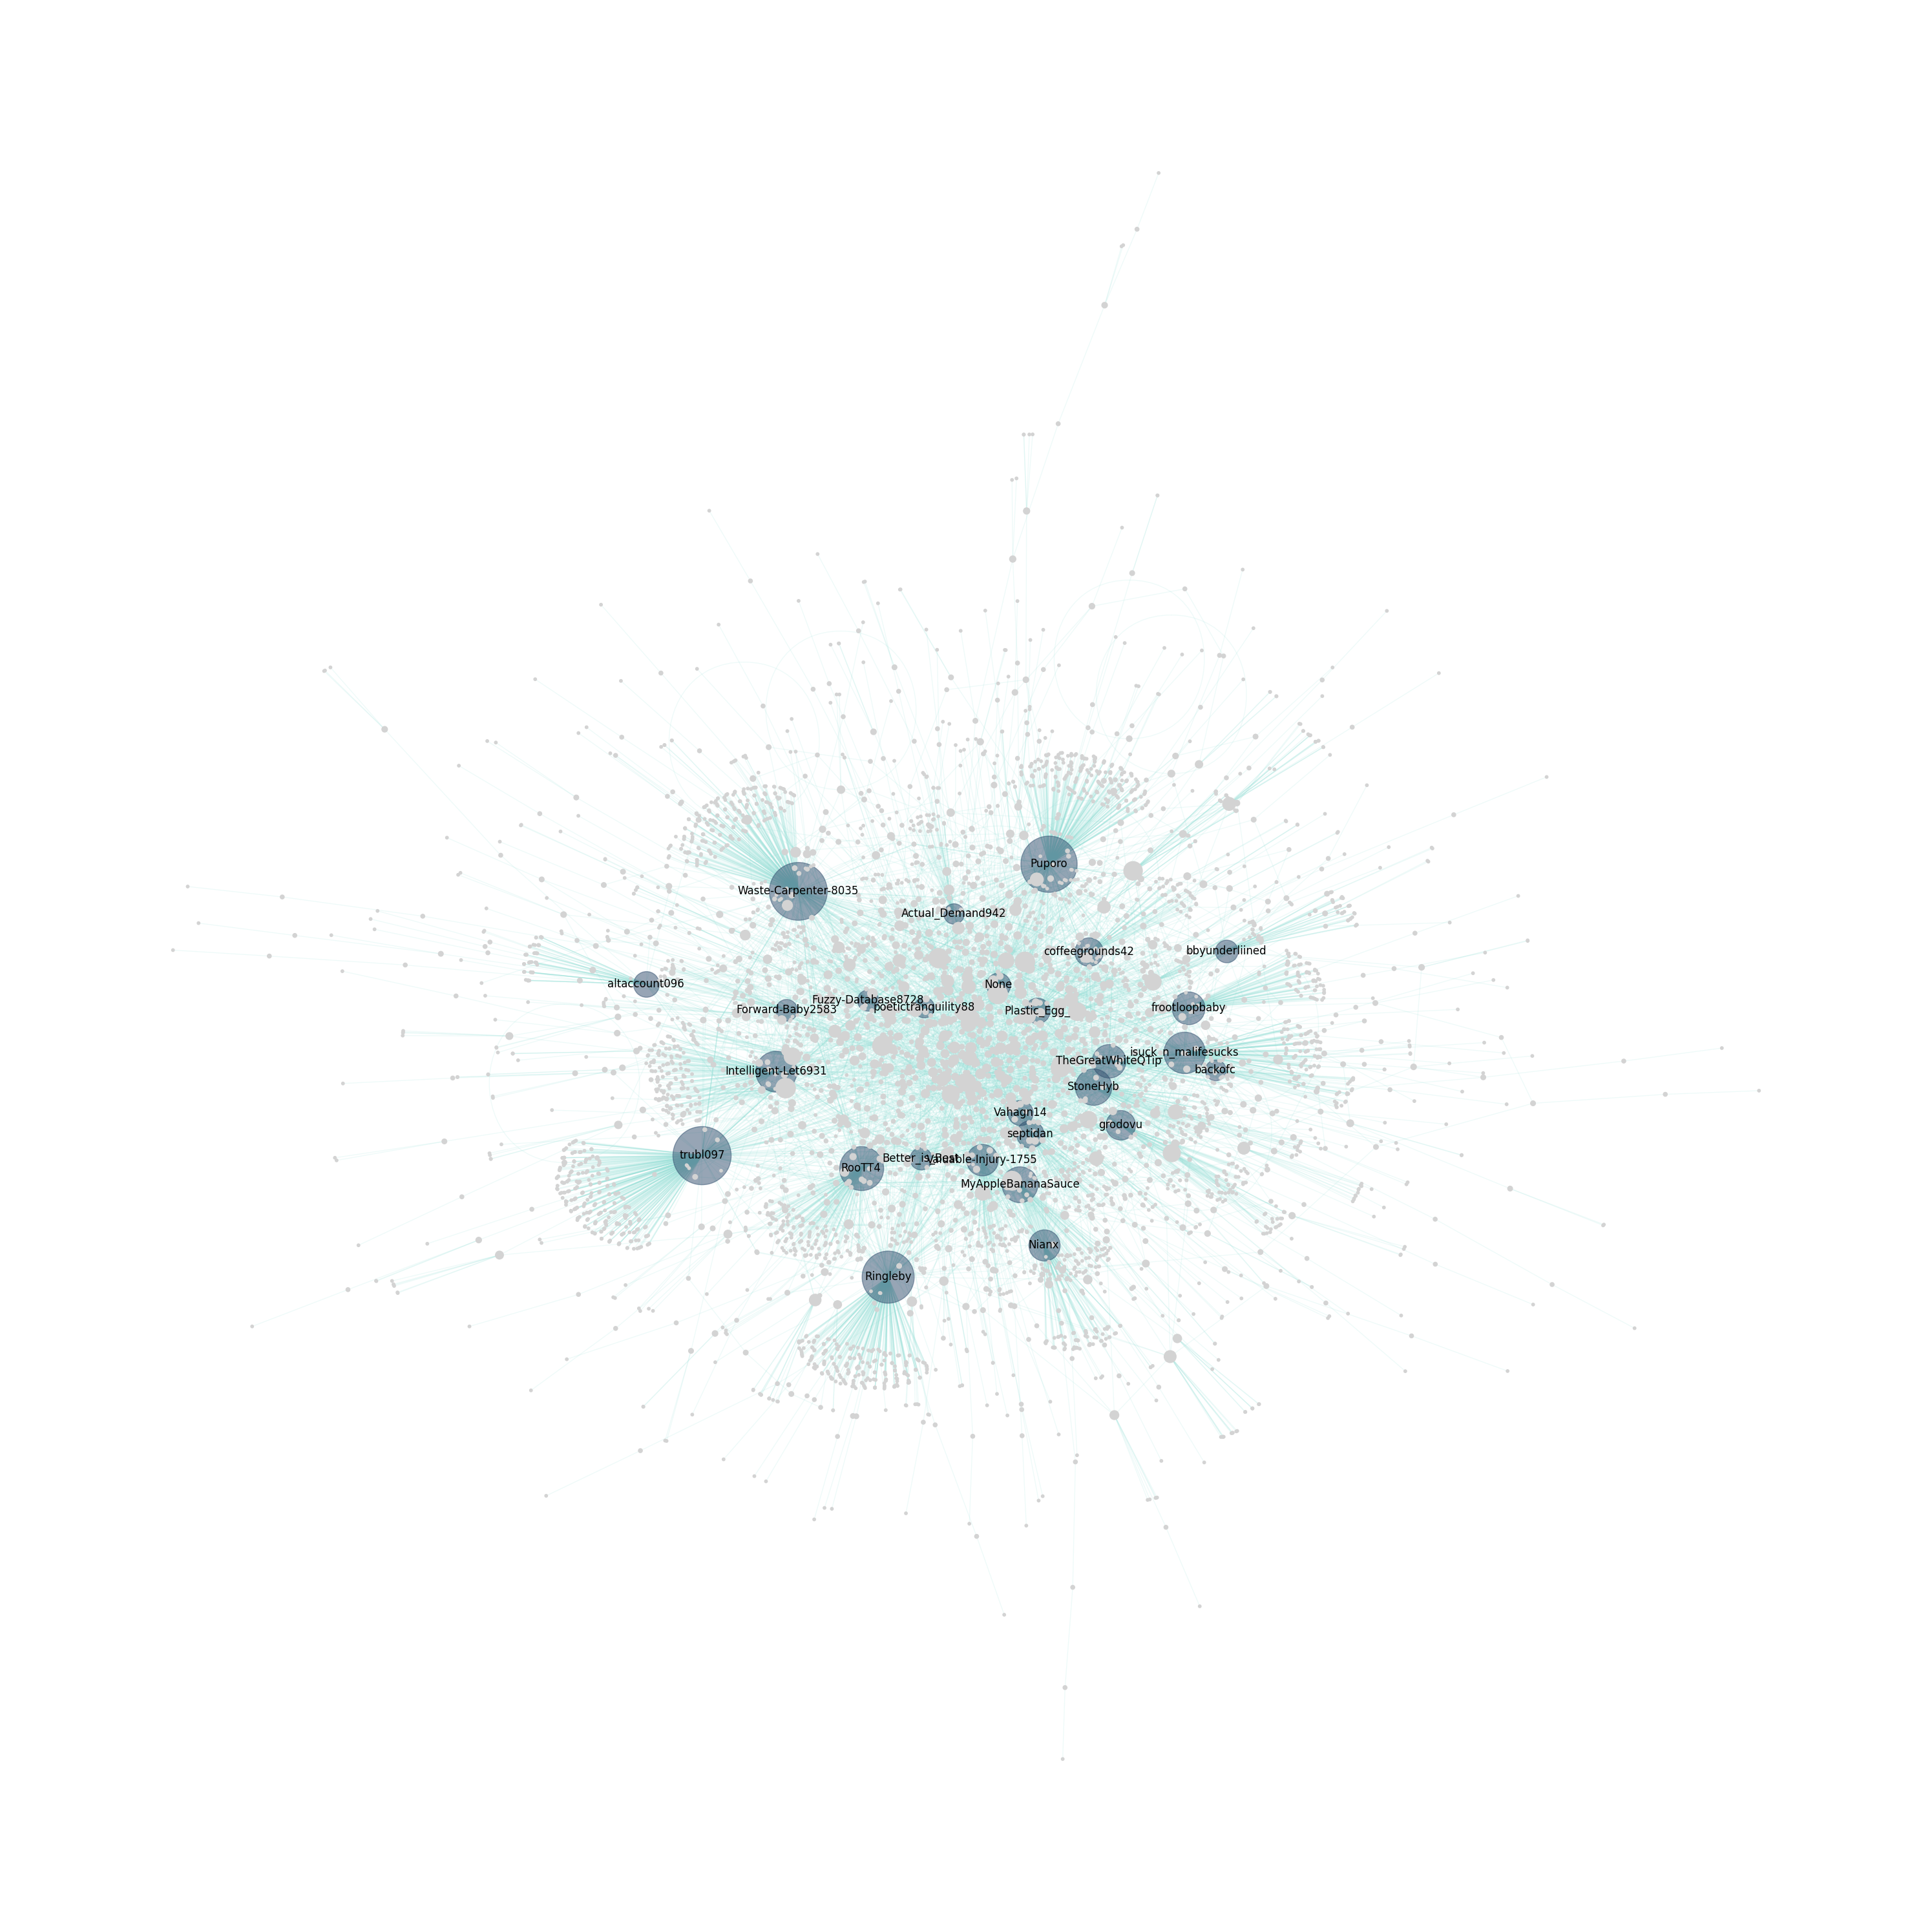

In [ ]:
plt.figure(figsize=(30,30))

# edge_colormap = plt.cm.viridis  # You can choose any colormap you prefer
# edge_color_values = np.linspace(0, 1, len(gg.edges))  # Values for colormap

# edge_colors = [edge_colormap(value) for value in edge_color_values]

for node in GG.nodes() :
    if node_sizes[list(GG.nodes()).index(node)] > 500:
        nx.draw_networkx_nodes(GG, pos, nodelist=[node], node_size=node_sizes[list(GG.nodes()).index(node)], alpha=0.5, node_color='#304D6D')
        nx.draw_networkx_labels(GG, pos, labels={node: node}, font_size=12)

other_nodes = [node for node in GG.nodes() if node_sizes[list(GG.nodes()).index(node)] <= 500]
nx.draw_networkx_nodes(GG, pos, nodelist=other_nodes, node_size=[node_sizes[list(GG.nodes()).index(node)] for node in other_nodes], node_color='lightgray')

nx.draw_networkx_edges(GG, pos, alpha=0.15, width=1, edge_color='#93E1D8')

plt.tight_layout()
plt.axis("off")
plt.show()

In [ ]:
GG.number_of_nodes()

5228

In [ ]:
GG.degree('trubl097')

421

In [ ]:
GG.degree('Waste-Carpenter-8035')

416

In [ ]:
df = pd.DataFrame( nx.degree(G), columns=['node', 'degree'] )
df.sort_values('degree', ascending=False).head()

node  degree
3082              trubl097     421
4244  Waste-Carpenter-8035     416
3678                Puporo     394
449               Ringleby     337
1504                RooTT4     241

In [ ]:
edgelist = pd.read_pickle("edgelist.pkl")

In [ ]:
G_1 = nx.Graph() # Creates a graph object
G_1.add_edges_from( edgelist[["source","target"]].values ) # Adds edges (and hence nodes from the edgelist)

CC_nodes_1 = list( nx.connected_components(G_1) )[0] # Generates a list of connected components, extracts the largest
GG_1 = nx.subgraph(G_1, CC_nodes_1) # Creates the subgraph of the largest CC

In [ ]:
pos_1 = nx.spring_layout(GG_1)

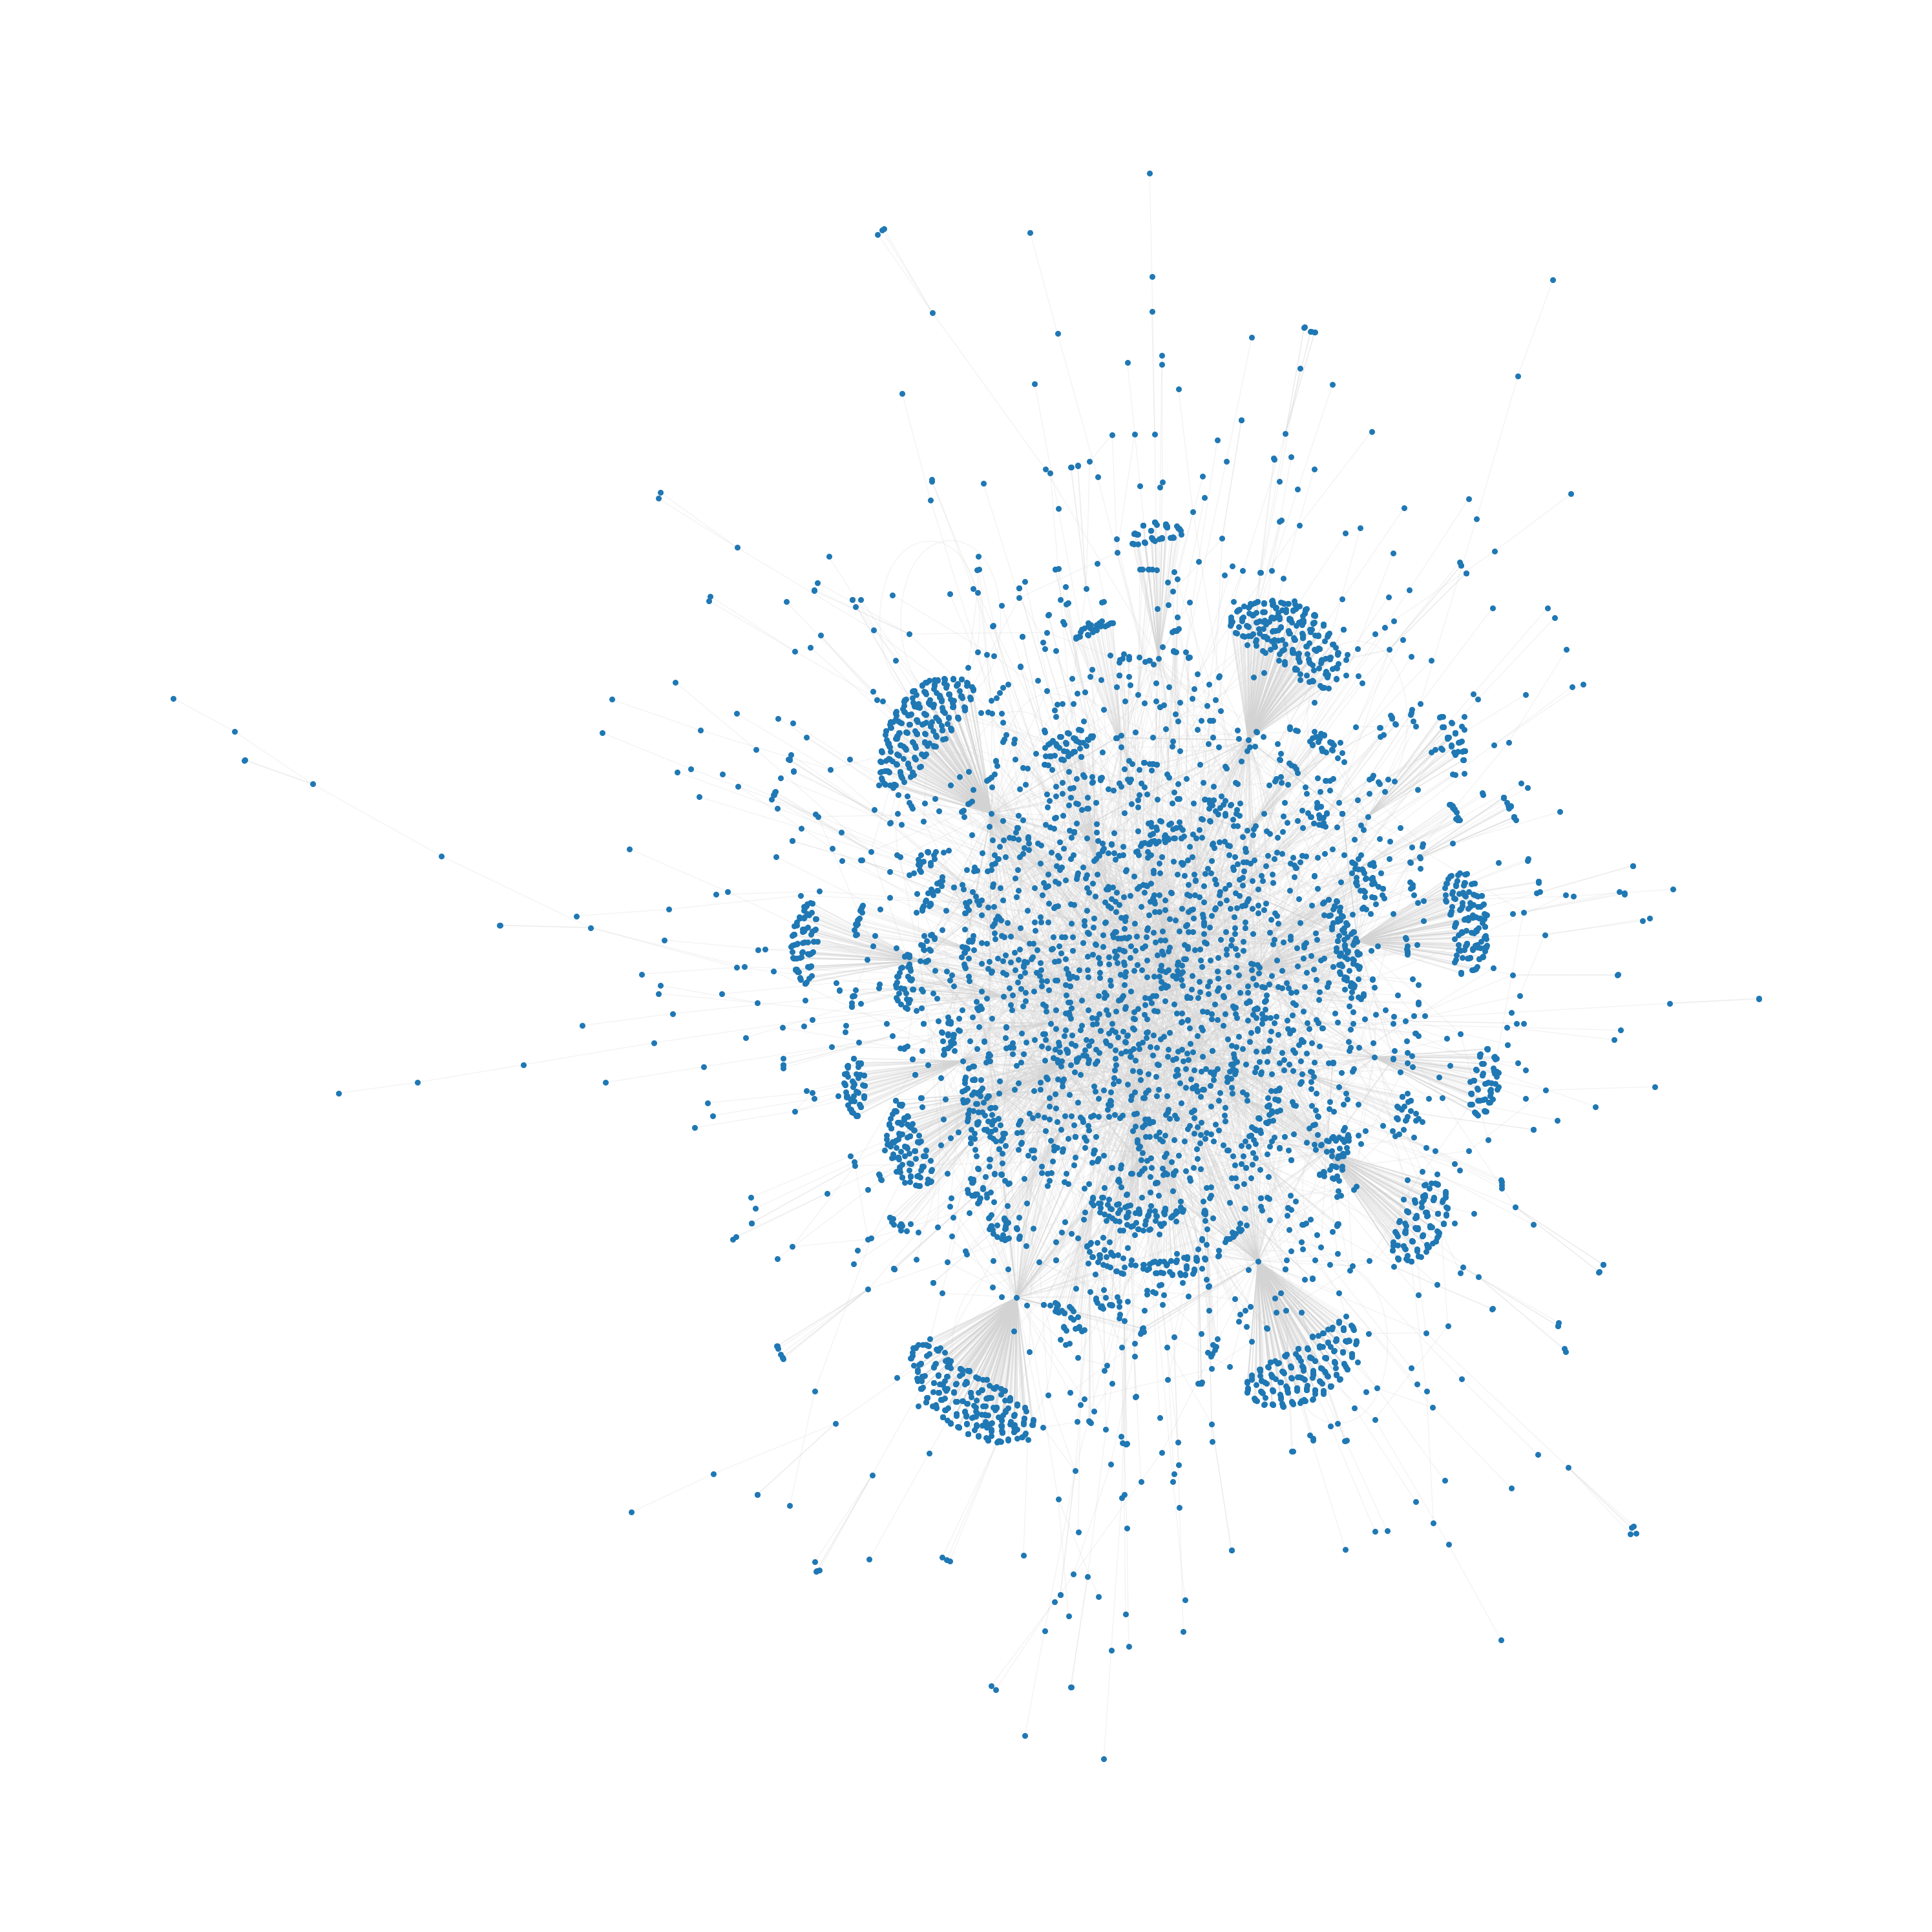

In [ ]:
plt.figure(figsize=(30,30))

nx.draw_networkx_nodes(GG_1, pos_1, node_size=30)
nx.draw_networkx_edges(GG_1, pos_1, alpha=0.25, width=1, edge_color='lightgray')

plt.tight_layout()
plt.axis("off")

plt.savefig('network_1.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

In [ ]:
GG_1.number_of_nodes()

5228

In [ ]:
df_1 = pd.DataFrame( nx.degree(GG_1), columns=['node', 'degree'] )
df_1.sort_values('degree', ascending=False)

node  degree
2969              trubl097     421
4067  Waste-Carpenter-8035     416
3549                Puporo     394
427               Ringleby     337
1454                RooTT4     241
...                    ...     ...
2319           cheetah7748       1
2321      googler-in-chief       1
2323   Mother-Anxiety-6981       1
2324         llamadasirena       1
5227               lghtspd       1

[5228 rows x 2 columns]

In [ ]:
df = pd.read_csv("comm557_submissions_df.csv", index_col=0)

In [ ]:
df.head()

id     full_id            author  \
0  1793g27  t3_1793g27        jelindrael   
1  1793f20  t3_1793f20       Babybabyyyx   
2  1793bb4  t3_1793bb4  Tip_Of_The_Sauce   
3  1793a88  t3_1793a88   Cursed_Creative   
4  17932t2  t3_17932t2       comingloose   

                                               title  \
0  What are books with only strategies on how to ...   
1                         Teach me how to be quieter   
2                     Not sure where to go from here   
3                    Forgetting that you remembered?   
4  what was the thing that finally helped you sto...   

                                                text  \
0  Basically, I am looking for a book that will j...   
1  I always feel bad when I talk too much regardl...   
2  My entire life I’ve been told that I have ADHD...   
3  I don't know if this is a new phenomenon for m...   
4  What’s been your “silver bullet” for getting a...   

                                                 url  is_self  \
0  https://www.reddit.com/r/ADHD/comments/1793g27...     True   
1  https://www.reddit.com/r/ADHD/comments/1793f20...     True   
2  https://www.reddit.com/r/ADHD/comments/1793bb4...     True   
3  https://www.reddit.com/r/ADHD/comments/1793a88...     True   
4  https://www.reddit.com/r/ADHD/comments/17932t2...     True   

           created_utc edited  num_comments  is_locked  is_over_18  score  \
0  2023-10-16 11:06:54  False             2      False       False      1   
1  2023-10-16 11:05:06  False             1      False       False      1   
2  2023-10-16 10:59:05  False             1      False       False      1   
3  2023-10-16 10:56:56  False             1      False       False      1   
4  2023-10-16 10:43:04  False             1      False       False      2   

   upvote_ratio                                               link  
0           1.0  /r/ADHD/comments/1793g27/what_are_books_with_o...  
1           1.0  /r/ADHD/comments/1793f20/teach_me_how_to_be_qu...  
2           1.0  /r/ADHD/comments/1793bb4/not_sure_where_to_go_...  
3           1.0  /r/ADHD/comments/1793a88/forgetting_that_you_r...  
4           1.0  /r/ADHD/comments/17932t2/what_was_the_thing_th...